# Project 4: Poisonous Mushrooms

**Solution**

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

## Grading
---
- Make sure to answer every part in every question.
 - There are 6 equally weighted questions.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Question 1:PCA and fraction of total variance
---

1. Do a principal components analysis on the data.
1. Print what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].
1. Show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
1. You only need to call PCA.fit once.

Notes:
* The pandas DataFrame [cumsum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) function may be helpful.
* You can use `PCA` to produce a PCA analysis.

In [5]:
#Test function to calculate pca using covariance
def pca1(matrix):
    cov_mat = np.cov(matrix.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    return(eig_vals, eig_vecs)

In [6]:
#Helper function to show line of cummulative variance explained by each pca using var_ratio
def varplot2(exp_var_ratio):
    
    cum_var_exp= np.cumsum(exp_var_ratio)

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 8))
        #plt.step(range(len(exp_var_ratio)), cum_var_exp, where='mid',label='cumulative explained variance')
        plt.plot(range(len(exp_var_ratio)), cum_var_exp, label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()

In [7]:
#Helper function to show line of cummulative variance explained by each pca using explained variation
def varplot1(exp_var):
    
    tot_variance = sum(exp_var)
    var_exp = [(i / tot_variance)*100 for i in sorted(exp_var, reverse=True)]
    cum_var_exp= np.cumsum(var_exp)

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(10, 8))

        #plt.step(range(len(var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
        plt.plot(range(len(var_exp)), cum_var_exp, label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()

Question 2: Print what fraction of the total variance in the training data is explained by the 
          first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].

     K  Var Prop Exp  Var Cum Prop Exp (%)
0    1      0.164043              0.164043
1    2      0.133235              0.297278
2    3      0.101735              0.399013
3    4      0.070634              0.469646
4    5      0.038666              0.508313
9   10      0.022309              0.652215
19  20      0.011464              0.808968
29  30      0.007003              0.898549
39  40      0.004398              0.950928
49  50      0.002045              0.982103

Question 3: Show a lineplot of fraction of total variance vs. 
    number of principal components, for all possible numbers of principal components. 


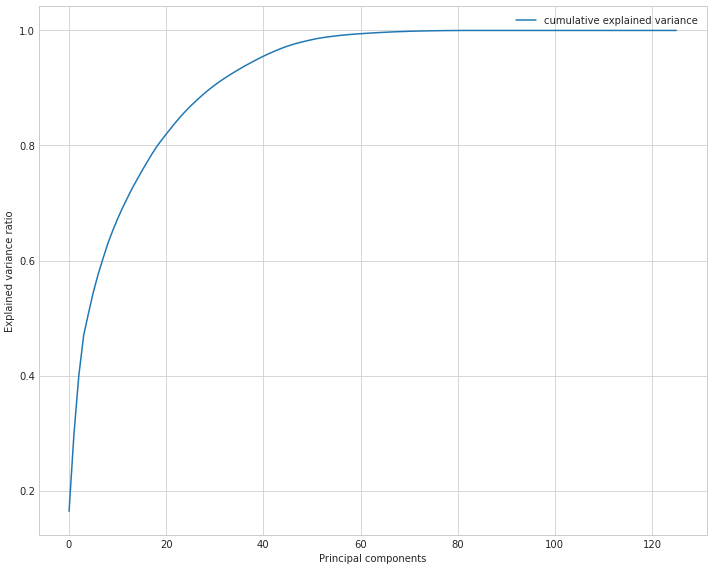

In [8]:
def P1():
    ## STUDENT START ###
    
    #List of PCA dimensions to be presented from dataframe
    k_list = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50]

    #Create and fit_transforma PCA model
    p1_pca = PCA()
    X_pca = p1_pca.fit_transform(train_data)
    
    #Store key information on PCA in dataframe to be presented lateer
    df_summary = pd.DataFrame({"K": range(1,p1_pca.explained_variance_ratio_.shape[0]+1),
                              "Var Prop Exp": p1_pca.explained_variance_ratio_,
                              "Var Cum Prop Exp (%)": np.cumsum(p1_pca.explained_variance_ratio_)})
        
    #Print Question 2:
    print("""Question 2: Print what fraction of the total variance in the training data is explained by the 
          first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].\n""")
    #Print summary information for PCA analysis for key number of dimensions
    print(df_summary[df_summary['K'].isin(k_list)])

    #Print graph of explained variance ratio (%) vs. number of dimensions
    print("""\nQuestion 3: Show a lineplot of fraction of total variance vs. 
    number of principal components, for all possible numbers of principal components. """)
    #varplot1(p1_pca.explained_variance_)
    varplot2(p1_pca.explained_variance_ratio_)
    
    #Testing calculations using covariance
    eva, eve = pca1(train_data)

    return(eva, eve)
    
    ## STUDENT END ###
eva, eve = P1()

In [ ]:
#eva, eve = sort_pca(eva, eve)
#varplot1(eva)

### Question 2: PCA for visualization

PCA can be very useful for visualizing data. 
1. Project the training data down to 2 dimensions and show as a square scatterplot.
  - Show poisonous examples (labeled 1) in red and non-poisonous examples in green (labeled 0)
  - Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.
* Be sure to add a title, axis labels and a legend to your graph.

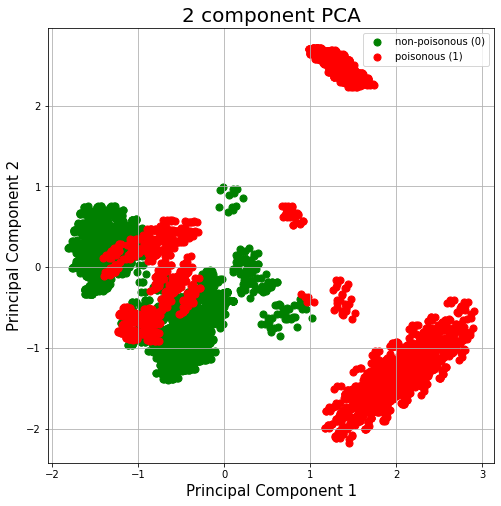

In [9]:
def Q2():   
  ### STUDENT START ###
    
    #Create, fit & transform PCA model with 2 ncomponents.
    p2_pca = PCA(n_components=2)
    X_pca = p2_pca.fit_transform(train_data)
    
    #Create Dataframe with PC1 and PC2 data to be used in graph
    pca_Df = pd.DataFrame(data = X_pca, columns = ['PC 1', 'PC 2'])
    pca_Df["Mushroom"] = train_labels
    
    #Create plot for PC1 vs. PC2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    
    #Define the categories for non-poisonous (0) in green & poisonous (1) in red
    targets = [0, 1]
    labels = ["non-poisonous (0)", "poisonous (1)"]
    colors = ['g', 'r']

    #For look to present the two type of mushrooms (non-poisonous vs poisonous)
    for target, color in zip(targets,colors):
        indicesToPresent = pca_Df["Mushroom"] == target
        ax.scatter(pca_Df.loc[indicesToPresent, 'PC 1'],   #Present scatter plot for two type of mushrooms
                   pca_Df.loc[indicesToPresent, 'PC 2'],   #using PC1 vs. PC2
                   c = color,
                   s = 50)
        
    ax.legend(labels)
    ax.grid()
    
    return(pca_Df)


  ### STUDENT END ###

df = Q2()

### Question 3: Visualizing GMMs
---

1. Fit a k-means cluster model with 6 clusters over the 2d projected data. 
  - As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  
  - For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

In [10]:
#Calculate the distance of a point and the center of the cluster
def distance(a,b,i,centers):
    return(np.linalg.norm(np.array([a,b])-centers[i]))

In [11]:
#Function to get the radious for each cluster
def get_radius(centers, df):

    #Initialize list for cluster radius
    radius = []

    # Create a column with the distance from point to the cluster it belongs to.
    df["dist"] = df.apply(lambda row: distance( row.PC1, row.PC2, int(row.Predict), centers), axis=1)
    
    # Get the list of Groups to set the limit for the for loop
    groups = df['Predict'].unique()
    
    # For each group, identify the points belonging to the cluster, find the maximum (radious), 
    # add to the list of radious
    for g in range(groups.max()+1):
        sel_index = np.where(df['Predict']==g)
        max_dist = df.iloc[sel_index]["dist"].max()
        radius.append(max_dist)
        
    return(radius)

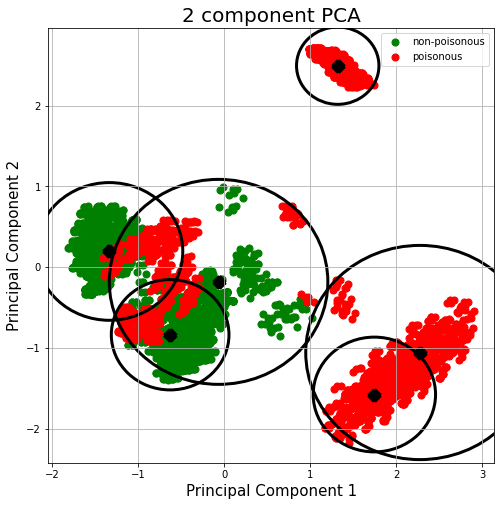

In [12]:
def Q3():   
  ### STUDENT START ###

    #Run Principal Components Analysis - 2 components
    p3_pca = PCA(n_components=2)
    X3_pca = p3_pca.fit_transform(train_data)
    
    #Run Clustering Model (KNN)
    mod3 = KMeans(n_clusters=6)

    #Alternative for GNN - only for testing
    #mod3 = GaussianMixture(n_components=6)  #JUST TO TEST GMM

    mod3.fit(X3_pca)
    
    #centers = mod3.means_
    centers = mod3.cluster_centers_

    #Create DataFrame with PCA, integrating predictions from Clustering
    pca_Df = pd.DataFrame(data = X3_pca, columns = ['PC1', 'PC2'])
    pca_Df["Mushroom"] = train_labels
    pca_Df["Predict"] = mod3.predict(X3_pca)
    
    #Scatterplot for Musrooms - non-poisonous in green, poisonous in red
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    
    #Define the categories for non-poisonous (0) in green & poisonous (1) in red
    targets = [0, 1]
    labels = ["non-poisonous", "poisonous"]
    colors = ['g', 'r']
    
    #For look to present the two type of mushrooms (non-poisonous vs poisonous)
    for target, color in zip(targets,colors):
        indicesToPresent = pca_Df["Mushroom"] == target
        ax.scatter(pca_Df.loc[indicesToPresent, 'PC1'], 
                   pca_Df.loc[indicesToPresent, 'PC2'],
                   c = color,
                   s = 50)
    
    #Present the centers for the clusters in graph
    plt.scatter(centers[:,0],centers[:,1], lw=12, color="black", marker='x')
    
    #Get the list of radious for each cluster
    rad_list = get_radius(centers, pca_Df)
    
    #Add Circle with corresponding radious
    i = 0
    for mean in centers:
        circle = plt.Circle(( mean[0] , mean[1] ), rad_list[i], color = 'black', fill=False, lw=3)
        ax.add_artist( circle )
        i += 1

    ax.legend(labels)
    ax.grid()
    
    return(pca_Df, mod3)


  ### STUDENT END ###

df1, gmm = Q3()

### Question 4: Understanding GMMs with Density Plots
---

1. Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. 
  - Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  
  - Show a 4x4 grid of square-shaped plots of the estimated density contours. 
    - Each row showing a different number of mixture components. 
    - Each column showing a different convariance matrix type.  
1. Be sure to add a title for each plot in the grid to indicate what parameters were used.
1. How are the covariance types 'tied' and 'full' different? How do you see it in the plots?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

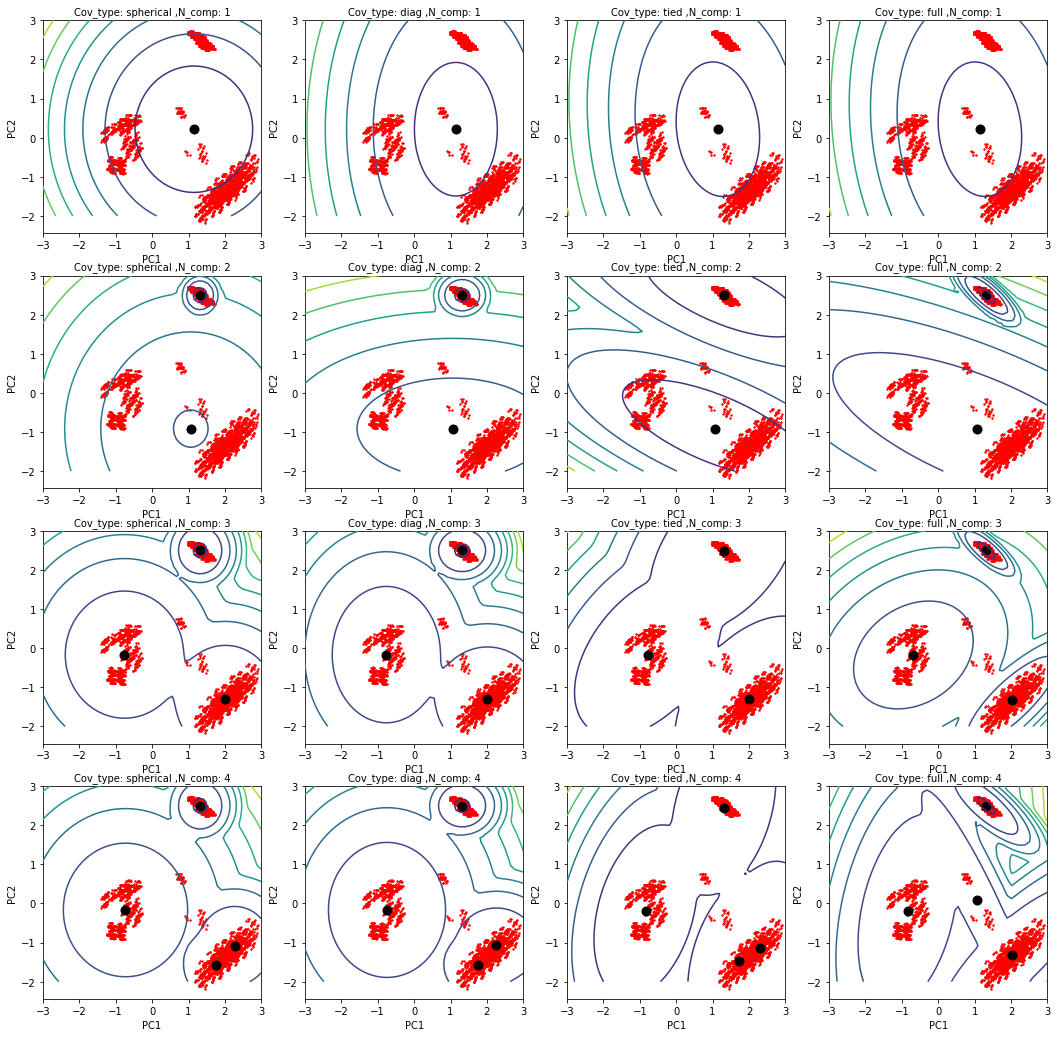

In [13]:
def Q4():
    
    ### STUDENT START ###
         
    #Run Principal Components Analysis - 2 components
    p4_pca = PCA(n_components=2)
    X4_pca_total = p4_pca.fit_transform(train_data)
     
    #Select Poisonous data only from 2d projected data
    #pois_index = np.where(train_labels==1)
    #X4_pca = X4_pca[pois_index]
    X4_pca = X4_pca_total[train_labels==1]
    #Y_pos = train_labels[pois_index]

    #List of parameters for running models
    cov_matrix = ['spherical','diag', 'tied','full']
    ncomp_list = [1, 2, 3, 4]
    color = ['black',  'b', 'g', 'm']
    
    #Set subplot matrix
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(18, 18))

    # Turn off tick marks.
    #plt.setp(ax, xticks=(), yticks=())


    #Run model for each covariance_type and n_componenets, and graph results in the gird
    i = 0
    for n_components in ncomp_list:
        j = 0
        for cv in cov_matrix:
            
            #Create and fit model for a given covariance type and n_components
            mod4 = GaussianMixture(n_components=n_components, covariance_type=cv, random_state=12345)
            mod4.fit(X4_pca)
            
            #Create DataFrame with PCA, integrating predictions from Clustering
            pca_Df = pd.DataFrame(data = X4_pca, columns = ['PC1', 'PC2'])
            #pca_Df["Mushroom"] = Y_pos
            pca_Df["Predict"] = mod4.predict(X4_pca)

            #Get the centers for the clusters
            centers = mod4.means_

            #Create scatter plos for the data
            ax[i,j].scatter(X4_pca[:,0],X4_pca[:,1], c = 'r', s = 2)
            
            #Present the centers for the clusters
            ax[i,j].scatter(centers[:,0],centers[:,1], color="black", lw=4)
            
            #Get the list of radious for each cluster
            #rad_list = get_radius(centers, pca_Df)

            # display predicted scores by the model as a contour plot
            size = 3
            size1 = 2
            x = np.linspace(-size, size)
            y = np.linspace(-size1, size)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -mod4.score_samples(XX)
            Z = Z.reshape(X.shape)
            
            #import warnings
            #warnings.filterwarnings("ignore")
            
            fontsize = 10
            #ax[i,j].contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
            ax[i,j].contour(X, Y, Z, zorder=3)
            title = "Cov_type: "+cv +" ,N_comp: "+str(n_components)
            ax[i,j].set_xlabel("PC1", fontsize=fontsize)
            ax[i,j].set_ylabel("PC2", fontsize=fontsize)

            ax[i,j].set_title(title, fontsize=fontsize)

            
            j += 1
            
        i += 1
    plt.show()
    
    ### STUDENT END ###

Q4()

**Answer: Q3 - How are the covariance types 'tied' and 'full' different? How do you see it in the plots?**
A Gaussian distribution is determined by its covariance matrix, while its mean indicate the location in the space (more like the center). The covariance matrix determines the directions and lengths of the axes of its density contours.

The difference between "full" and "tied" can be seen in the shape of the contours.  
- For "tied" (all clusters share the same general covariance matrix), the clusters have different covariance along PC1 and PC2, and all the cluster share the same covariance along the dimensions.  Thus, the shape of the clusters (in 'tied') are similar, as it can be seen in the plots.
- For "full" (each cluster has its own general covariance matrix), the clusters have different covariance along PC1 and PC2, and each cluster have different covariance matrix.  Thus, every cluster has its unique shape.  In other words, the components may independently adopt any position and shape for each cluster.

#### Useful References for future:
- https://stats.stackexchange.com/questions/326671/different-covariance-types-for-gaussian-mixture-models
- https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

### Question 5: Using Unsupervised models for classification...?
---

1. Fit two Gaussian mixture models:
  - On your 2d projected training data. 
    - Form a subset of all the poisonous examples and fit one GMM (gmm_poison).
    - Form a subset of all the non-poisonous examples and fit another GMM (gmm_nonpoison).
  - Use 4 mixture components and full convariance for each model.  
1. Use the above trained GMMs to classify examples in your test set:
   - For each example in the test set
     - Measure how likely it is to have been "generated" by gmm_poison and gmm_nonpoison (using score_samples).
     - Predict the more likely label.
  - You can use score_samples.
  - You can do this without a for loop which will be more efficient.
1. What is the accuracy of the predictions on the test data? (we expect it to be about 0.95)

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [14]:
def pred_label(a,b):
    if a > b: return(0)
    else: return(1)

In [15]:
def Q5():  
  ### STUDENT START ###

    #Run Principal Components Analysis - 2 components
    p5_pca = PCA(n_components=2)
    X5_pca = p5_pca.fit_transform(train_data)
    
    #1. Fit two Gaussian mixture models: On your 2d projected training data.
    
    # - Form a subset of all the poisonous examples and fit one GMM (gmm_poison).
    #Select Poisonous data only from 2d projected data
    pois_index = np.where(train_labels==1)
    X5_pca_pois = X5_pca[pois_index]
    Y_pos = train_labels[pois_index]
    
    #Create and run GMM model with poisonous data
    GMM_poison = GaussianMixture(n_components=4, covariance_type="full", random_state=12345)
    GMM_poison.fit(X5_pca_pois)
    
    # - Form a subset of all the non-poisonous examples and fit another GMM (gmm_nonpoison).
    #Select No Poisonous data only from 2d projected data
    no_pois_index = np.where(train_labels==0)
    X5_pca_no_pois = X5_pca[no_pois_index]
    Y_npos = train_labels[no_pois_index]

    #Create and run GMM model with no poisonous data
    GMM_no_poison = GaussianMixture(n_components=4, covariance_type="full", random_state=12345)
    GMM_no_poison.fit(X5_pca_no_pois)
    
    #Transform the test data - Note: do not do fit_transform, as it was already fitted above
    test_pca = p5_pca.transform(test_data)
    
    #Get predictions and calculate accuracy
    predictions = np.exp(GMM_poison.score_samples(test_pca)) > np.exp(GMM_no_poison.score_samples(test_pca))
    accuracy = (test_labels == predictions).mean()
    print('Question 5.3: What is the accuracy of the predictions on the test data? (we expect it to be about 0.95)')
    print("Accuracy = ",accuracy)

  ### STUDENT END ###

Q5()

Question 5.3: What is the accuracy of the predictions on the test data? (we expect it to be about 0.95)
Accuracy =  0.9501779359430605


### Question 6: Understanding the GMM parameters
---

1. Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.
1. Print the best configuration and accuracy.
1. Plot a scatter plot of accuracy vs #params.
1. Bonus: Provide a better visualization by showing all four: accuracy, number of parameters, the covariance type and the number of PCA dimensions.



Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* [This spreadsheet](https://docs.google.com/spreadsheets/d/1LTEOU7q_Tgs4bX_3o2ePjDQrTRToZoc1J5XLlaRbmI0/edit?usp=sharing) should help (accessible from your google @berkeley.edu account)

* Spherical - Each GMM component has a mean per dimension, and one variance. 
* Diag - Each GMM component has a mean per dimension and a variance for each dimension.
* full - Each GMM component has a mean per dimension and a "full" covariance matrix. Only the covariance matrix is symmetric, so its $[i,j]$ entry would equal to its $[j,i]$ entry.
* tied - Finally, tied has all components share a single covariance matrix. So each GMM component has a mean per dimension but they all share the same 'full' covariance matrix.

2. The best configuration and accuracy:
{'best_cm': 'tied', 'best_n_comp': 3, 'best_n_params': 48.0, 'best_accuracy': 0.9697508896797153, 'best_PCA': 4}

3. Plot a scatter plot of accuracy vs Number of params - color coded for covariance_type:


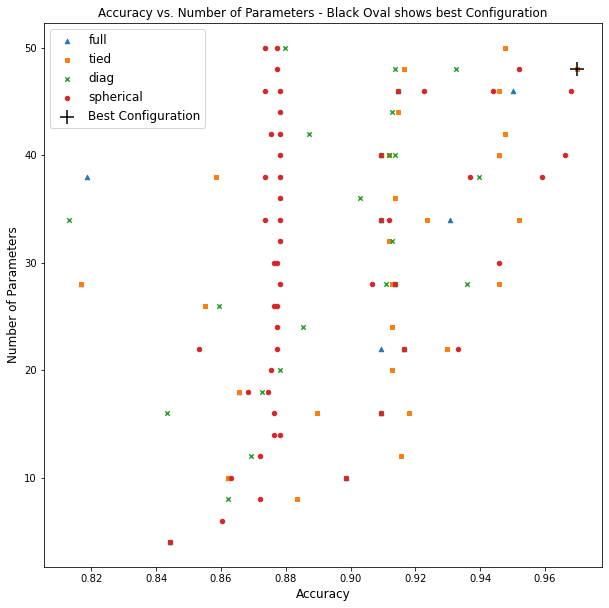

For more clarity, I am plotting results for each Covariance Matrix in an independent plot:


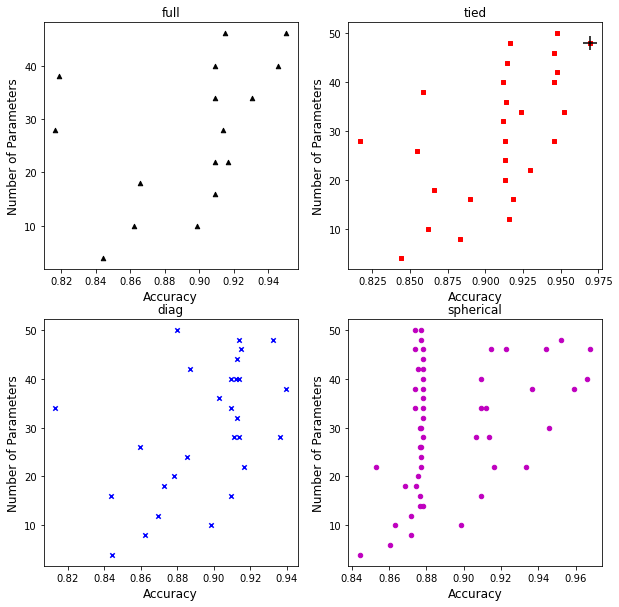


4. Bonus: Provide a better visualization by showing all four: accuracy, number of parameters, the covariance type and the number of PCA dimensions.


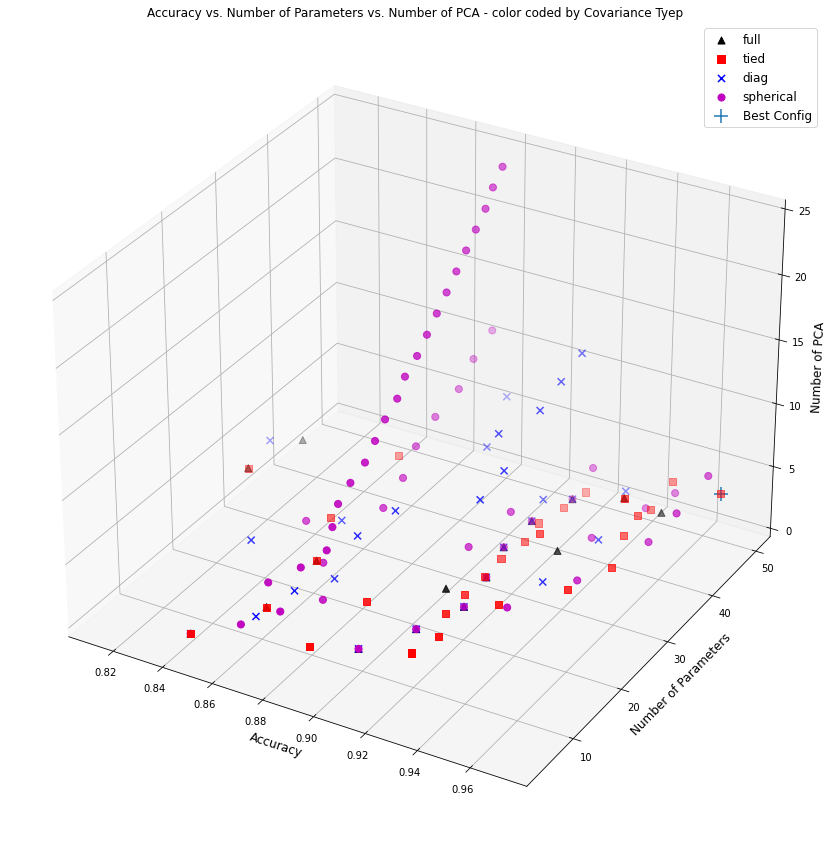

In [17]:
from matplotlib.lines import Line2D

def Q6():
  ### STUDENT START ###

    n_classes = 2
    best_accuracy = 0
    n_params_limit = 50
    
    cm_list = []
    pca_list = []
    n_comp_list = []
    npar_list = []
    acc_list = []
    max_accuracy = 0
    best_config = {}

    pca_components = range(1,50)
    gmm_comp = range(1,50)
    cov_matrix = ['full', 'tied', 'diag', 'spherical']
        
    #pca_comp = n_vars for PCA components; n_comp = number of components for GMM
    for pca_comp in pca_components:
        for n_comp in gmm_comp:
            for cm in cov_matrix:
                
                if cm == 'spherical':
                    n_params_per_gaussian = pca_comp + 1 + 1
                    n_params = (n_params_per_gaussian * n_comp -1)*n_classes
                elif cm == 'diag':
                    n_params_per_gaussian = pca_comp + pca_comp + 1
                    n_params = (n_params_per_gaussian * n_comp -1)*n_classes
                elif cm == 'tied':
                    n_params_per_gaussian = ((pca_comp + 1)*n_comp) + (pca_comp + (pca_comp * pca_comp - pca_comp)/2)
                    n_params = (n_params_per_gaussian-1)*n_classes
                else: #for full
                    n_params_per_gaussian = pca_comp + (pca_comp+(pca_comp*pca_comp - pca_comp)/2) + 1
                    n_params = (n_params_per_gaussian*n_comp - 1)*n_classes
                    
                    
                if n_params <= n_params_limit:

                    #Create and fit PCA model
                    pca = PCA(n_components=pca_comp)
                    TD_pca = pca.fit_transform(train_data)
                    
                    #Select data for non poisonous; create and fit GMM model for nonpoisonous
                    npois_index = np.where(train_labels == 0)
                    TD_npois = TD_pca[npois_index]
                    
                    mod_npois = GaussianMixture(n_components=n_comp, covariance_type=cm, random_state=12345)
                    mod_npois.fit(TD_npois)
                    
                    #Select data for non poisonous; create and fit GMM model for nonpoisonous
                    pois_index = np.where(train_labels == 1)
                    TD_pois = TD_pca[pois_index]
                    
                    mod_pois = GaussianMixture(n_components=n_comp, covariance_type=cm, random_state=12345)
                    mod_pois.fit(TD_pois)
                    
                    #Transform the test data - Note: do not do fit_transform, as it was already fitted above
                    test_pca = pca.transform(test_data)

                    predictions = np.exp(mod_pois.score_samples(test_pca)) > np.exp(mod_npois.score_samples(test_pca))
                    accuracy = (predictions == test_labels).mean()
                    
                    if accuracy > max_accuracy:
                        best_config["best_cm"] = cm
                        best_config["best_n_comp"] = n_comp
                        best_config["best_n_params"] = n_params
                        best_config["best_accuracy"] = accuracy
                        best_config["best_PCA"] = pca_comp
                        max_accuracy = accuracy

                    cm_list.append(cm)
                    n_comp_list.append(n_comp)
                    pca_list.append(pca_comp)
                    npar_list.append(n_params)
                    acc_list.append(accuracy)
    
    df_summary = pd.DataFrame()
    df_summary['Cov Matrix'] = cm_list
    df_summary['n_comp'] = n_comp_list
    df_summary['pca_num'] = pca_list
    df_summary['n_params'] = npar_list
    df_summary['accuracy'] = acc_list
    
    #print(df_summary.head())
    
    print("2. The best configuration and accuracy:")
    print(best_config)
    
    print("\n3. Plot a scatter plot of accuracy vs Number of params - color coded for covariance_type:")
    
    #Set subplot matrix
    figsize = 10
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize, figsize))
    adjustment = 1
    
    colors = ['black', 'r', 'b', 'm']
    marker = ['^', 's', 'x', 'o']
    for cm, c, m in zip(cov_matrix,colors,marker):
        x = df_summary[df_summary['Cov Matrix'] == cm]['accuracy']
        y = df_summary[df_summary['Cov Matrix'] == cm]['n_params']/adjustment
        ax.scatter(x,y, s = 20, label=cm, marker=m)
        #ax.plot(x,y, label=cm, marker=m)
        ax.set_xlabel("Accuracy",fontsize=12)
        ax.set_ylabel("Number of Parameters", fontsize=12)
        
    #circle = plt.Circle(( best_config['best_accuracy'] , best_config['best_n_params']/adjustment ), 0.005, color = 'black', fill=False, lw=1)
    #ax.add_artist( circle )
    ax.scatter(best_config['best_accuracy'] , best_config['best_n_params']/adjustment, 
               color='black', marker='+', s=200, label="Best Configuration")
    ax.legend(fontsize=12)
    plt.title("Accuracy vs. Number of Parameters - Black Oval shows best Configuration")
    plt.show()


    #Set subplot matrix - one plot for each covariance_type
    print("""For more clarity, I am plotting results for each Covariance Matrix in an independent plot:""")
    figsize = 10
    fig, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(figsize, figsize))
    adjustment = 1
    
    colors = ['black', 'r', 'b', 'm']
    marker = ['^', 's', 'x', 'o']
    n, i, j = 0, 0, 0
    for cm, c, m in zip(cov_matrix,colors,marker):
        x = df_summary[df_summary['Cov Matrix'] == cm]['accuracy']
        y = df_summary[df_summary['Cov Matrix'] == cm]['n_params']/adjustment
        ax2[i,j].scatter(x,y, s = 20, label=cm, marker=m, c = c)
        ax2[i,j].set_xlabel("Accuracy",fontsize=12)
        ax2[i,j].set_ylabel("Number of Parameters", fontsize=12)
        ax2[i,j].set_title(cm)
        if best_config['best_cm'] == cm:
            ax2[i,j].scatter(best_config['best_accuracy'] , best_config['best_n_params']/adjustment, 
                       color='black', marker='+', s=200, label="Best Configuration")
        n += 1
        if n==1: j = 1
        elif n==2: i , j = 1, 0
        else: j = 1
        
    
    ax.legend(fontsize=12)
    plt.show()

    
    print("\n4. Bonus: Provide a better visualization by showing all four: accuracy, number of parameters, the covariance type and the number of PCA dimensions.")

    figsize = 15
    fig = plt.figure(figsize=(figsize,figsize))
    ax1 = plt.axes(projection='3d')
    
    colors = ['black', 'r', 'b', 'm']
    marker = ['^', 's', 'x', 'o']
    for cm, c, m in zip(cov_matrix,colors,marker):
        x = df_summary[df_summary['Cov Matrix'] == cm]['accuracy']
        y = df_summary[df_summary['Cov Matrix'] == cm]['n_params']
        z = df_summary[df_summary['Cov Matrix'] == cm]['pca_num']
        ax1.scatter3D(x,y,z, s = 50, label=cm, marker=m, c = c)
        ax1.set_xlabel("Accuracy",fontsize=12)
        ax1.set_ylabel("Number of Parameters", fontsize=12)
        ax1.set_zlabel("Number of PCA", fontsize=12)
    ax1.scatter3D( best_config['best_accuracy'] , best_config['best_n_params'], 
                   best_config['best_PCA'], s = 200, label="Best Config", marker='+')
    ax1.legend(fontsize=12)
    plt.title("Accuracy vs. Number of Parameters vs. Number of PCA - color coded by Covariance Tyep")
    plt.show()

  ### STUDENT END ###

Q6()

**Some Useful References:**

- https://vitalflux.com/gaussian-mixture-models-what-are-they-when-to-use/
- https://notebook.community/gtzan/mir_book/Clustering%20using%20Gaussian%20Mixture%20Models%20and%20PCA
- https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

For plotting in 3d:  
- https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
- https://matplotlib.org/stable/tutorials/toolkits/mplot3d.html


**Other Comments bout GMM: For future reference.**
The Gaussian Mixture Model have four different type of covariances:
- spherical: where each component has its own single variance. Giving an spherical shape for the clusters.
- diag: each component has its own diagonal covariance matrix.
- tied: all components share the same general covariance matrix
- full: each component has its own general covariance matrix.

In a "diag" covariance the size of the cluster along each dimension can be defined independently which result in an elliptic shape aligned with the axes. In a covariance_type="spherical", it constrains the shape of the cluster such that all dimensions are equal, which results in a spheric shape (similar, but not equivalent to k-means). A covariance_type="full" allows each cluster to be modeled as an ellipse with arbitrary orientation, thus each cluster may adopt a different shape to adjust to the data.  Finally, in a covariance_type="tied" the clusters may have different covariance along the dimensions, however all clusters share the same covariance matrix.  Thus all clusters share the same shape.
